# Align spike sequences in GISAID and count RBD mutations
This Python Jupyter notebook reads in a file of all spike sequences from GISAID, parses for "high-quality" sequences, builds a RBD alignment, and then makes a file that gives the counts of each mutation at each site.

## Set up analysis
Import Python modules:

In [1]:
import io
import lzma
import os
import re
import subprocess

from Bio.Data.IUPACData import protein_letters
import Bio.SeqIO

from IPython.display import display, HTML

import matplotlib.pyplot as plt

import pandas as pd

from plotnine import *

import yaml

Read the configuration file:

In [2]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Create output directory:

In [3]:
os.makedirs(config['gisaid_mutations_dir'], exist_ok=True)

## Parse full-length human human spike sequences

Read the spikes from the file downloaded from GISAID:

In [4]:
print(f"Reading GISAID spikes in {config['gisaid_spikes']}")
# file is `xz` compressed
with lzma.open(config['gisaid_spikes'], 'rt') as f:
    spikes = list(Bio.SeqIO.parse(f, 'fasta'))   
print(f"Read {len(spikes)} spike sequences.")

Reading GISAID spikes in data/spikeprot0315.tar.tar.xz
Read 765455 spike sequences.


Make a data frame that has the BioPython SeqRecord, length, host, and geographic location (country) for each spike.
Also determine whether sequences have ambiguous amino acids or are all valid amino acids:

In [5]:
spikes_df = (
    pd.DataFrame({'seqrecord': spikes})
    .assign(description=lambda x: x['seqrecord'].map(lambda rec: rec.description),
            country=lambda x: x['description'].str.split('|').str[-1],
            host=lambda x: x['description'].str.split('|').str[6].str.strip(),
            length=lambda x: x['seqrecord'].map(len),
            n_ambiguous=lambda x: x['seqrecord'].map(lambda rec: rec.seq.count('X') + rec.seq.count('x')),
            )
    )

Show number of sequences from different hosts, then keep only human ones:

In [6]:
display(HTML(
    spikes_df
    .groupby('host')
    .aggregate(n_sequences=pd.NamedAgg('seqrecord', 'count'))
    .sort_values('n_sequences', ascending=False)
    .to_html()
    ))

spikes_df = spikes_df.query('host == "Human"')

,n_sequences
host,
Human,764112
Neovison vison,902
Environment,358
Felis catus,23
Mustela lutreola,13
Manis javanica,12
human,9
Panthera tigris jacksoni,6
Canis lupus familiaris,5


Plot distribution of lengths and only keep sequences that are full-length (or near full-length) spikes:

Distribution of length for all spikes:


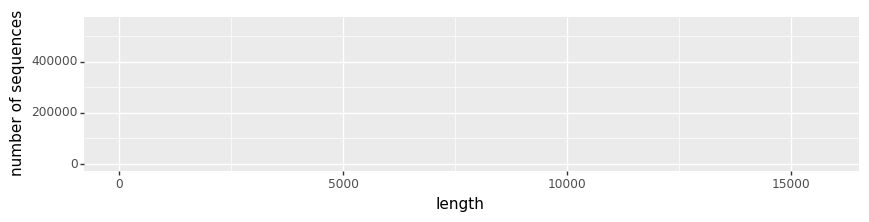


Only keeping spikes with lengths between 1260 and 1276
Here are number of sequences with valid and invalid lengths:


,n_sequences
valid_length,
False,42959
True,721153



Distribution of lengths for sequences with valid and invalid lengths; dotted red lines delimit valid lengths:


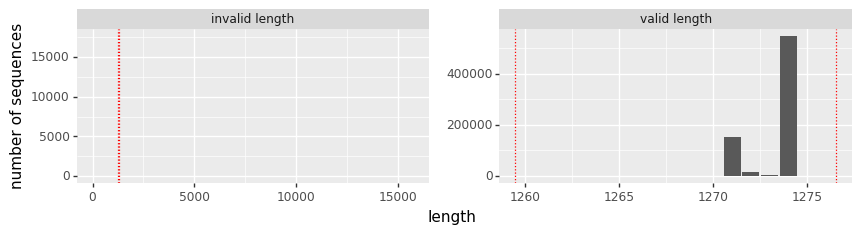

In [7]:
print('Distribution of length for all spikes:')
p = (ggplot(spikes_df) +
     aes('length') +
     geom_bar() +
     ylab('number of sequences') +
     theme(figure_size=(10, 2))
     )
fig = p.draw()
display(fig)
plt.close(fig)

min_length, max_length = 1260, 1276
print(f"\nOnly keeping spikes with lengths between {min_length} and {max_length}")
spikes_df = (
    spikes_df
    .assign(valid_length=lambda x: (min_length <= x['length']) & (x['length'] <= max_length))
    )

print('Here are number of sequences with valid and invalid lengths:')
display(HTML(spikes_df
             .groupby('valid_length')
             .aggregate(n_sequences=pd.NamedAgg('seqrecord', 'count'))
             .to_html()
             ))

print('\nDistribution of lengths for sequences with valid and invalid lengths; '
      'dotted red lines delimit valid lengths:')
p = (ggplot(spikes_df
            .assign(valid_length=lambda x: x['valid_length'].map({True: 'valid length',
                                                                  False: 'invalid length'}))
            ) +
     aes('length') +
     geom_bar() +
     ylab('number of sequences') +
     theme(figure_size=(10, 2), subplots_adjust={'wspace': 0.2}) +
     facet_wrap('~ valid_length', scales='free') +
     geom_vline(xintercept=min_length - 0.5, color='red', linetype='dotted') +
     geom_vline(xintercept=max_length + 0.5, color='red', linetype='dotted')
     )
fig = p.draw()
display(fig)
plt.close(fig)

spikes_df = spikes_df.query('valid_length')

Finally, we get rid of spikes with **lots** of ambiguous residues as they may hinder the alignment below.
We will then do more detailed filtering for ambiguous residues just in the RBD region after alignment:

In [8]:
max_ambiguous = 100
print(f"Filtering sequences with > {max_ambiguous} ambiguous residues")
spikes_df = (
    spikes_df
    .assign(excess_ambiguous=lambda x: x['n_ambiguous'] > max_ambiguous)
    )
display(HTML(
    spikes_df
    .groupby('excess_ambiguous')
    .aggregate(n_sequences=pd.NamedAgg('seqrecord', 'count'))
    .to_html()
    ))

Filtering sequences with > 100 ambiguous residues


,n_sequences
excess_ambiguous,
False,689785
True,31368


## Align the RBD region of the spikes
We now align the RBD regions of the spikes.
We do this **before** we filter sequences with too many ambiguous residues so that we can do that filtering just on the RBD region.

We align with `mafft` using the `--addfragments` and `--keeplength` options (see [here](https://mafft.cbrc.jp/alignment/software/closelyrelatedviralgenomes.html) and [here](https://mafft.cbrc.jp/alignment/software/addsequences.html)) to align relative to a reference that is just the RBD; these options also clip the sequences relative to the reference.
Note that these options make sense if the following conditions are met:
  1. Sequences are all very similar.
  2. We are not worried about insertions.
For now, both of these appear to be true, but this choice should be kept in mind if there is a lot more divergence or insertions.

We align relative to the reference that is the wildtype sequence used for the experiments:

In [9]:
print(f"Reading reference nucleotide sequence in {config['wildtype_sequence']}")
refseq = Bio.SeqIO.read(config['wildtype_sequence'], 'fasta')

refprotfile = os.path.join(config['gisaid_mutations_dir'], 'reference_RBD.fasta')
print(f"Writing protein translation of reference sequence to {refprotfile}")
refseq.seq = refseq.seq.translate()
_ = Bio.SeqIO.write(refseq, refprotfile, 'fasta')

Reading reference nucleotide sequence in data/wildtype_sequence.fasta
Writing protein translation of reference sequence to results/GISAID_mutations/reference_RBD.fasta


Write all the other spikes to a file:

In [10]:
spikes_file = os.path.join(config['gisaid_mutations_dir'],
                           'human_full-length_spikes.fasta')
print(f"Writing the spikes to {spikes_file}")
_ = Bio.SeqIO.write(spikes_df['seqrecord'].tolist(), spikes_file, 'fasta')

Writing the spikes to results/GISAID_mutations/human_full-length_spikes.fasta


Now make the alignment.
Note that we use multiple threads to speed things up, and also align the spikes in chunks.
The reason that we have to the chunkwise alignment is that some unclear `mafft` error was arising if we tried to align them all at once:

In [11]:
chunksize = 50000

aligned_rbds = []

for i in range(0, len(spikes_df), chunksize):
    spikes_file = os.path.join(config['gisaid_mutations_dir'],
                               f"human_full-length_spikes_{i + 1}-to-{i + chunksize}.fasta")
    print(f"Writing spikes {i + 1} to {i + chunksize} to {spikes_file}")
    _ = Bio.SeqIO.write(spikes_df['seqrecord'].tolist()[i: i + chunksize], spikes_file, 'fasta')
    print('Now aligning these sequences...')
    cmds = ['mafft', '--auto', '--thread', str(config['max_cpus']),
            '--keeplength', '--addfragments', spikes_file, refprotfile]
    res = subprocess.run(cmds, capture_output=True)
    if res.returncode:
        raise RuntimeError(f"Error in alignment:\n{res.stderr}")
    else:
        print('Alignment complete.\n')
        with io.StringIO(res.stdout.decode('utf-8')) as f:
            iseqs = list(Bio.SeqIO.parse(f, 'fasta'))
            # remove reference sequence, which should be first in file
            assert iseqs[0].seq == refseq.seq and iseqs[0].description == refseq.description
            iseqs = iseqs[1:]
            assert len(iseqs) == min(chunksize, len(spikes_df) - i)
            aligned_rbds += iseqs
            
assert len(aligned_rbds) == len(spikes_df)

Writing spikes 1 to 50000 to results/GISAID_mutations/human_full-length_spikes_1-to-50000.fasta
Now aligning these sequences...
Alignment complete.

Writing spikes 50001 to 100000 to results/GISAID_mutations/human_full-length_spikes_50001-to-100000.fasta
Now aligning these sequences...
Alignment complete.

Writing spikes 100001 to 150000 to results/GISAID_mutations/human_full-length_spikes_100001-to-150000.fasta
Now aligning these sequences...
Alignment complete.

Writing spikes 150001 to 200000 to results/GISAID_mutations/human_full-length_spikes_150001-to-200000.fasta
Now aligning these sequences...
Alignment complete.

Writing spikes 200001 to 250000 to results/GISAID_mutations/human_full-length_spikes_200001-to-250000.fasta
Now aligning these sequences...
Alignment complete.

Writing spikes 250001 to 300000 to results/GISAID_mutations/human_full-length_spikes_250001-to-300000.fasta
Now aligning these sequences...
Alignment complete.

Writing spikes 300001 to 350000 to results/GISAI

## Parse / filter aligned RBDs

Now put all of the aligned RBDs into a data frame to filter and parse:

In [12]:
rbd_df = (
    pd.DataFrame({'seqrecord': aligned_rbds})
    .assign(description=lambda x: x['seqrecord'].map(lambda rec: rec.description),
            country=lambda x: x['description'].str.split('|').str[-1],
            host=lambda x: x['description'].str.split('|').str[6].str.strip(),
            length=lambda x: x['seqrecord'].map(len),
            n_ambiguous=lambda x: x['seqrecord'].map(lambda rec: rec.seq.count('X') + rec.seq.count('x')),
            n_gaps=lambda x: x['seqrecord'].map(lambda rec: rec.seq.count('-')),
            all_valid_aas=lambda x: x['seqrecord'].map(lambda rec: re.fullmatch(f"[{protein_letters}]+",
                                                                                str(rec.seq)) is not None),
            )
    )

assert all(rbd_df['length'] == len(refseq))

Plot number of gaps and ambiguous nucleotides among sequences:

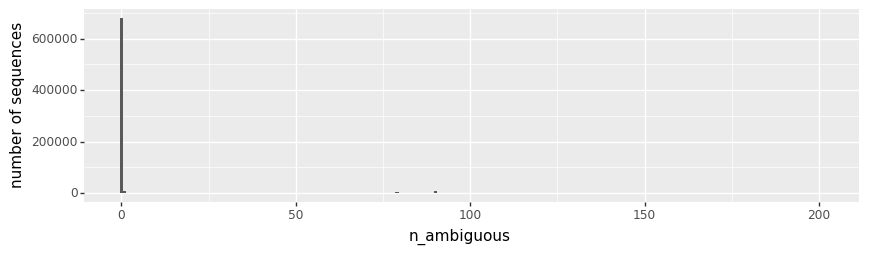

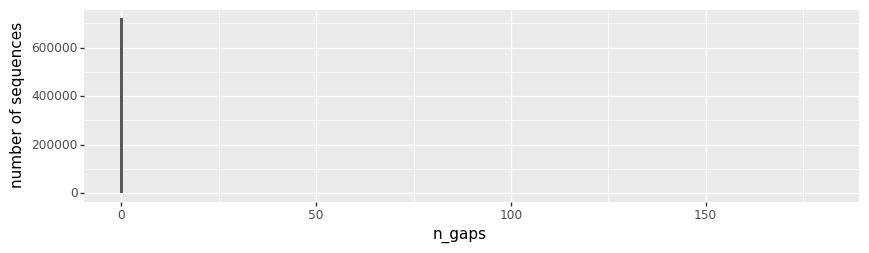

In [13]:
for prop in ['n_ambiguous', 'n_gaps']:
    p = (ggplot(rbd_df) +
         aes(prop) +
         ylab('number of sequences') +
         theme(figure_size=(10, 2.5)) +
         geom_bar()
         )
    _ = p.draw()

Based on above plots, we will retain just RBDs with no ambiguous amino acids and no gaps:

In [14]:
rbd_df = rbd_df.query('n_ambiguous == 0').query('n_gaps == 0')
assert rbd_df['all_valid_aas'].all()
print(f"Retained {len(rbd_df)} RBDs.")

Retained 679502 RBDs.


Now get and plot the number of amino-acid mutations per RBD relative to the reference sequence, plotting on both a linear and log scale.
We then filter all RBDs that have more than some maximum number of mutations, based on the idea that ones that are extremely highly mutated probably are erroneous.
**Note that this maximum number of mutations will change over time, so should be re-assessed periodically by looking at below plots.**

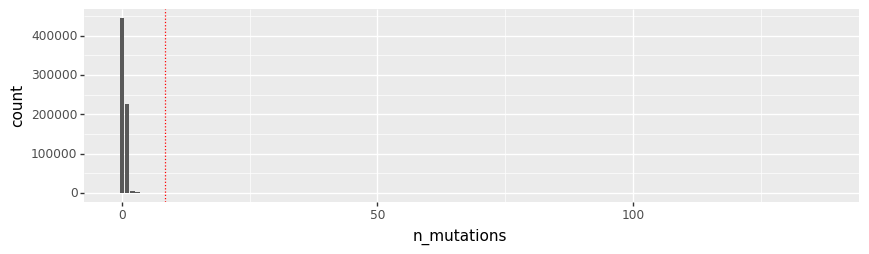

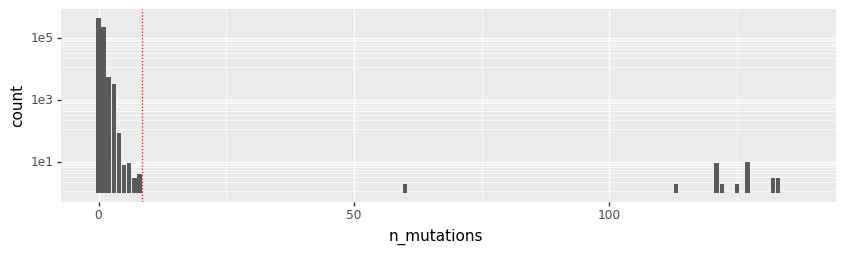

In [15]:
max_muts = 8

refseq_str = str(refseq.seq)
rbd_df = (
    rbd_df
    .assign(seq=lambda x: x['seqrecord'].map(lambda rec: str(rec.seq)),
            n_mutations=lambda x: x['seq'].map(lambda s: sum(x != y for x, y in zip(s, refseq_str))))
    )

p = (ggplot(rbd_df) +
     aes('n_mutations') +
     geom_bar() +
     theme(figure_size=(10, 2.5)) +
     geom_vline(xintercept=max_muts + 0.5, color='red', linetype='dotted')
     )
_ = p.draw()
_ = (p + scale_y_log10()).draw()

rbd_df = rbd_df.query('n_mutations <= @max_muts')

Write RBD sequences that pass filtering to a file:

In [16]:
print(f"Overall, there are {len(rbd_df)} aligned RBDs that passed filters.")

rbd_alignment_file = os.path.join(config['gisaid_mutations_dir'], 'RBD_alignment.fasta')
print(f"Writing alignment to {rbd_alignment_file}")
_ = Bio.SeqIO.write(rbd_df['seqrecord'].tolist(), rbd_alignment_file, 'fasta')

Overall, there are 679454 aligned RBDs that passed filters.
Writing alignment to results/GISAID_mutations/RBD_alignment.fasta


## Get counts of each mutation
Now we get a data frame that gives the count of each mutation at each site:

In [17]:
records = []
for tup in rbd_df[['seq', 'country']].itertuples():
    for isite, (mut, wt) in enumerate(zip(tup.seq, refseq_str), start=1):
        if mut != wt:
            records.append((isite, isite + config['site_number_offset'], wt, mut, tup.country))
            
muts_df = (pd.DataFrame.from_records(records,
                                     columns=['isite', 'site', 'wildtype', 'mutant', 'country'])
           .groupby(['isite', 'site', 'wildtype', 'mutant'])
           .aggregate(count=pd.NamedAgg('country', 'count'),
                      n_countries=pd.NamedAgg('country', 'nunique'))
           .reset_index()
           .sort_values('count', ascending=False)
           .assign(frequency=lambda x: x['count'] / len(rbd_df))
           )

print('Here are first few lines of mutation counts data frame:')
display(HTML(muts_df.head(n=15).to_html(index=False)))

Here are first few lines of mutation counts data frame:


isite,site,wildtype,mutant,count,n_countries,frequency
171,501,N,Y,154979,194,0.228093
147,477,S,N,30314,106,0.044615
122,452,L,R,14285,68,0.021024
109,439,N,K,13097,102,0.019276
154,484,E,K,7651,108,0.011261
87,417,K,N,3010,62,0.004430
148,478,T,K,2550,36,0.003753
164,494,S,P,2067,49,0.003042
190,520,A,S,1694,48,0.002493
171,501,N,T,1426,35,0.002099


Plot how many mutations are observed how many times:

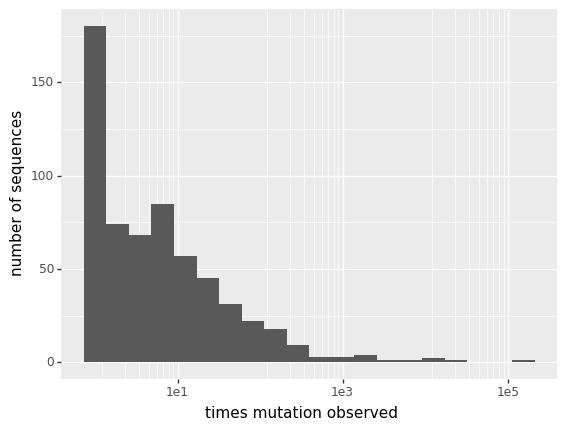

In [18]:
p = (ggplot(muts_df) +
     aes('count') +
     geom_histogram(bins=20) +
     scale_x_log10() +
     ylab('number of sequences') +
     xlab('times mutation observed')
     )

_ = p.draw()

Write the mutation counts to a file:

In [19]:
print(f"Writing mutation counts to {config['gisaid_mutations_dir']}")
muts_df.to_csv(config['gisaid_mutation_counts'], index=False)

Writing mutation counts to results/GISAID_mutations
